# Baseline 
Pour une baseline naïve, nous pourrions deviner la même valeur pour tous les exemples de l'ensemble de test. On nous demande de prédire la probabilité de ne pas rembourser le prêt, donc si nous sommes totalement incertains, nous devinerions 0,5 pour toutes les observations de l'ensemble de test. Cela nous donnera une zone caractéristique de fonctionnement du récepteur sous la courbe (AUC ROC) de 0,5 dans la compétition ([une classification aléatoire obtiendra un 0,5](https://stats.stackexchange.com/questions/266387/can-auc-roc-be-between-0-0-5)).

Puisque nous savons déjà quel score nous allons obtenir, nous n’avons pas vraiment besoin de faire une estimation naïve. Utilisons un modèle légèrement plus sophistiqué pour notre référence actuelle : la régression logistique.
Nous commencerons par analyse quelles sont les paramètres les plus adaptés à notre régression logistique puis nous les appliquerons à notre modèle.

In [1]:
import pandas as pd
import numpy as np
import time
import shap
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns

Pour analyser la pertinence du modèle que nous sélectionnerons, nous devons créer une fonction qui pénalise les mauvaises prédiction et plus particulièrement les False Negative. Ce sont des prédictions du modèle qui prédise un 0 alors que nous attendons un 1. Cette prédiction est plus dangereuse pour la pertinence du modèle car si nous prédisons un remboursement probable d'un crédit et que cela n'est pas le cas, cela impacte directement la rentabilité de la banque, ce qui n'est pas souhaitable.

In [91]:
def custom_penalty(y_test, y_pred):
    y_test = y_test.to_numpy().flatten()
    penalty = 0.0
    sum_penalty = 0
    
    for yt, yp in zip(y_test, y_pred):
        if yt == 1 and yp == 0:
            penalty = penalty + 10
            sum_penalty = sum_penalty +1
        elif yt == 0 and yp == 1:
            penalty = penalty + 1
            sum_penalty = sum_penalty +1
            
    score = (penalty/len(y_test))*0.1#/ (sum_penalty + 1e-7) # Prevents zero division
    return score

In [92]:
X_train = pd.read_csv('X_train_CSV.csv')
X_test = pd.read_csv('X_test_CSV.csv')
y_train = pd.read_csv('y_train_CSV.csv')
y_test = pd.read_csv('y_test_CSV.csv')

In [93]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [94]:
logistic_model = LogisticRegression(C= 1, penalty='l1', solver='liblinear')

In [95]:
scores = cross_val_score(logistic_model, X_train_scaled, y_train, cv=5,\
                         scoring='neg_mean_squared_error')
print("Scores de validation croisée:", scores)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Scores de validation croisée: [-0.284375 -0.28375  -0.2975   -0.281875 -0.290625]


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Nous affichons le temps de traitement de notre modèle qui nous serviras de metric pour sélectionner le plus performant.

In [96]:
start_time = time.time()
logistic_model.fit(X_train_scaled, y_train)
end_time = time.time()
execution_time = end_time - start_time
print(f"Le temps de traitement est de : {execution_time} secondes")

Le temps de traitement est de : 0.16610503196716309 secondes


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [97]:
test_score = logistic_model.score(X_test, y_test)
test_score

X has feature names, but LogisticRegression was fitted without feature names


0.574

In [98]:
y_pred = logistic_model.predict(X_test_scaled)

In [99]:
accuracy_score(y_test, y_pred)

0.7015

Nous affichons la précisions du modèle avec une pénalité si notre modèle crée des False Negative

In [100]:
custom_penalty(y_test, y_pred)

0.20985

In [75]:
from sklearn import metrics
print("RMSE : %.2f" % np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

RMSE : 0.55


In [76]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred)
auc_score

0.6794568222342182

In [77]:
explainer = shap.Explainer(logistic_model, X_train_scaled)
shap_values = explainer.shap_values(X_test_scaled)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


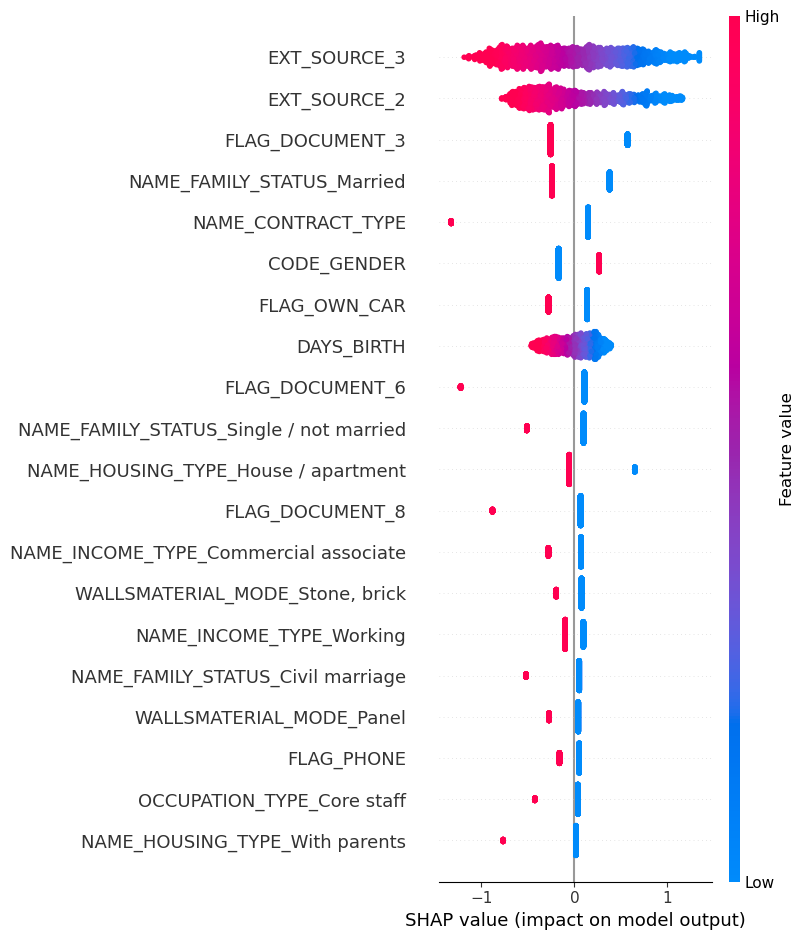

In [78]:
feature_names = X_test.columns.tolist()
shap.summary_plot(shap_values, X_test_scaled, feature_names=feature_names)

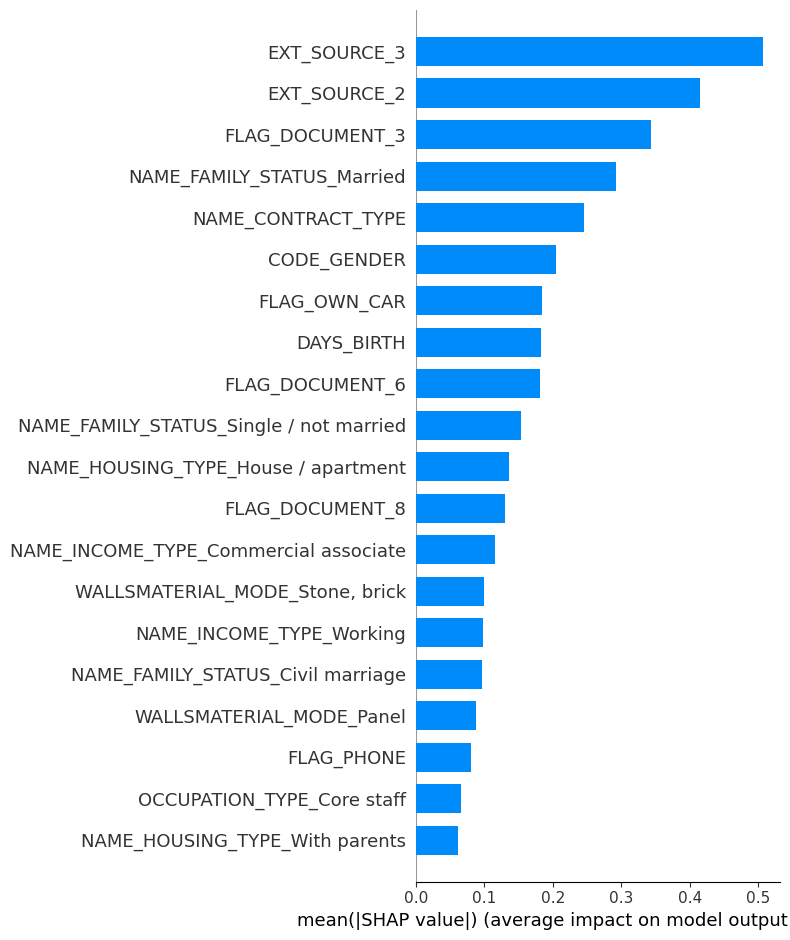

In [79]:
shap.summary_plot(shap_values, X_test_scaled, plot_type="bar", feature_names=feature_names)

## KNN

In [80]:
import pandas as pd
import numpy as np
from numpy import nan
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

In [81]:
X_train = pd.read_csv('X_train_CSV.csv')
X_test = pd.read_csv('X_test_CSV.csv')
y_train = pd.read_csv('y_train_CSV.csv')
y_test = pd.read_csv('y_test_CSV.csv')

In [82]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the

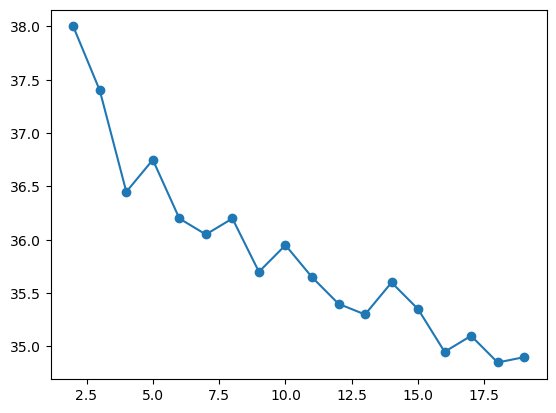

In [23]:
errors = []
for k in range(2,20):
    knn = KNeighborsClassifier(k)
    errors.append(100*(1 - knn.fit(X_train_scaled, y_train).score(X_test_scaled, y_test)))
plt.plot(range(2,20), errors, 'o-')
plt.show()

In [83]:
classifier = KNeighborsClassifier(n_neighbors=18, p=2, metric='euclidean')

In [84]:
scores = cross_val_score(classifier, X_train_scaled, y_train, cv=5,\
                         scoring='neg_mean_squared_error')
print("Scores de validation croisée:", scores)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Scores de validation croisée: [-0.328125 -0.30375  -0.325    -0.3425   -0.346875]


In [85]:
start_time = time.time()
classifier.fit(X_train_scaled, y_train)
end_time = time.time()
execution_time = end_time - start_time
print(f"Le temps de traitement est de : {execution_time} secondes")

Le temps de traitement est de : 0.008122682571411133 secondes


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [86]:
test_score = classifier.score(X_test, y_test)
test_score

X has feature names, but KNeighborsClassifier was fitted without feature names


0.574

In [87]:
y_pred = classifier.predict(X_test_scaled)

In [88]:
accuracy_score(y_test, y_pred)

0.6515

Nous affichons la précisions du modèle avec une pénalité si notre modèle crée des False Negative

In [89]:
custom_penalty(y_test, y_pred)

2.7335

In [31]:
from sklearn import metrics
print("RMSE : %.2f" % np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

RMSE : 0.59


In [32]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred)
auc_score

0.6162319445126042

## SVM

In [33]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC  # pour la classification, ou SVR pour la régression
from sklearn.metrics import accuracy_score, classification_report

In [34]:
X_train = pd.read_csv('X_train_CSV.csv')
X_test = pd.read_csv('X_test_CSV.csv')
y_train = pd.read_csv('y_train_CSV.csv')
y_test = pd.read_csv('y_test_CSV.csv')

In [35]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [36]:
svm_model = SVC(kernel='linear', cache_size=1000)
svm_model.fit(X_train_scaled, y_train)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


SVC(cache_size=1000, kernel='linear')

In [37]:
y_pred = svm_model.predict(X_test_scaled)

In [40]:
custom_penalty(y_test, y_pred)

4272.0

In [38]:
from sklearn import metrics
print("RMSE : %.2f" % np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

RMSE : 0.55


In [39]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred)
auc_score

0.6769396869018992

## Forêt aléatoire

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

In [42]:
X_train = pd.read_csv('X_train_CSV.csv')
X_test = pd.read_csv('X_test_CSV.csv')
y_train = pd.read_csv('y_train_CSV.csv')
y_test = pd.read_csv('y_test_CSV.csv')

In [43]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [44]:
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest_model.fit(X_train_scaled, y_train)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestClassifier(random_state=42)

In [45]:
y_pred = random_forest_model.predict(X_test_scaled)

In [46]:
custom_penalty(y_test, y_pred)

4662.0

In [47]:
from sklearn import metrics
print("RMSE : %.2f" % np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

RMSE : 0.56


In [48]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred)
auc_score

0.6615894554317776

## Test différents hyper-paramètres pour le modèle de forêt aléatoire

In [49]:
X_train = pd.read_csv('X_train_CSV.csv')
X_test = pd.read_csv('X_test_CSV.csv')
y_train = pd.read_csv('y_train_CSV.csv')
y_test = pd.read_csv('y_test_CSV.csv')

In [50]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [51]:
random_forest_model = RandomForestClassifier()
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(estimator=random_forest_model,\
                           param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_va

/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_va

/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_va

/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_va

/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_va

/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_va

/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_va

/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_va

/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_va

/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_va

/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_va

/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_va

/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_va

/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_va

/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_va

/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_va

/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_va

/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_va

/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_va

/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaeldelescluse/.local/lib/python3.10/site-packages/sklearn/model_selection/_va

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             verbose=2)

In [52]:
best_params = grid_search.best_params_
best_score = grid_search.best_score_
best_model = grid_search.best_estimator_
best_model_score = best_model.score(X_test_scaled, y_test)
print(best_params)
print(best_score)
print(best_model)
print(best_model_score)

{'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
0.71175
RandomForestClassifier(max_depth=30, n_estimators=200)
0.6905


In [53]:
random_forest_model = RandomForestClassifier(max_depth=30,\
                                             min_samples_leaf=2,\
                                             min_samples_split=5, n_estimators=200)
random_forest_model.fit(X_train_scaled, y_train)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestClassifier(max_depth=30, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=200)

In [54]:
y_pred = random_forest_model.predict(X_test_scaled)

In [55]:
custom_penalty(y_test, y_pred)

4682.0

In [56]:
from sklearn import metrics
print("RMSE : %.2f" % np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

RMSE : 0.55


In [57]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred)
auc_score

0.6641842927483601

## SVM à noyau

In [58]:
X_train = pd.read_csv('X_train_CSV.csv')
X_test = pd.read_csv('X_test_CSV.csv')
y_train = pd.read_csv('y_train_CSV.csv')
y_test = pd.read_csv('y_test_CSV.csv')

In [59]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [60]:
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale')
svm_model.fit(X_train_scaled, y_train)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


SVC()

In [61]:
y_pred = svm_model.predict(X_test_scaled)

In [62]:
custom_penalty(y_test, y_pred)

4652.0

In [63]:
from sklearn import metrics
print("RMSE : %.2f" % np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

RMSE : 0.55


In [64]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred)
auc_score

0.669713402365412

[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   4.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   2.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   1.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   2.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   1.9s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.0s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.0s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   4.0s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estim

[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   4.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   4.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   2.0s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.0s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.0s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.0s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.0s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.0s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimator

[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   4.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   4.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   3.9s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   4.0s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.0s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   1.0s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   1.9s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   2.0s
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=2, n_es

[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   1.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   2.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   1.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   1.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   2.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   4.0s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estima